Semantic Segmentation 
============

In this task, you will be focusing on semantic segmentation, a computer vision technique. Unlike image classification, the objective here is not to classify the entire image as a whole, but rather to classify each individual pixel within the image. Consequently, the network's output is not a single value but a segmentation map with the same dimensions as the input image. Think about why convolutional layers are preferable over fully-connected layers for this particular task.


<img src='https://i2dl.vc.in.tum.de/static/images/exercise_10//segmentation.jpg'/>

## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [17]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_10) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_10'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)

# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)

# Check manually if all files are present
print(sorted(os.listdir()))

"""

"\nfrom google.colab import drive\nimport os\n\ngdrive_path='/content/gdrive/MyDrive/i2dl/exercise_10'\n\n# This will mount your google drive under 'MyDrive'\ndrive.mount('/content/gdrive', force_remount=True)\n\n# In order to access the files in this notebook we have to navigate to the correct folder\nos.chdir(gdrive_path)\n\n# Check manually if all files are present\nprint(sorted(os.listdir()))\n\n"

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU


# 1. Preparation

## Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn

#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup TensorBoard
In exercise 07 you've already learned how to use TensorBoard. Let's use it again to make the debugging of our network and training process more convenient! As you progress through this notebook, don't hesitate to incorporate additional logs or visualizations in TensorBoard to further enhance your understanding and monitoring of the network's behavior.

In [19]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs/introduction')

In [20]:
%load_ext tensorboard
%tensorboard --logdir ./ --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16785), started 0:07:53 ago. (Use '!kill 16785' to kill it.)

## Load and Visualize Data

#### MSRC-v2 Segmentation Dataset

The MSRC-v2 dataset is an expanded version of the MSRC-v1 dataset, originally created by Microsoft Research in Cambridge. This dataset consists of 591 images, each annotated with accurate pixel-level labels. It contains 23 distinct object classes like bike, bird, car, house or tree.


The image ids are stored in the txt file `train.txt`, `val.txt`, `test.txt`. The dataloader will read the image id in the txt file and fetch the corresponding input and target images from the image folder. 
<img src='https://i2dl.vc.in.tum.de/static/images/exercise_10/input_target.png'/>



As you can see in `exercise_code/data/segmentation_dataset.py`, each segmentation label has its corresponding RGB value stored in the `SEG_LABELS_LIST`. The label `void` means `unlabeled`, and it is displayed as black `"rgb_values": [0, 0, 0]` in the target image. The target image pixels will be labeled based on its color using `SEG_LABELS_LIST`.

```python
                SEG_LABELS_LIST = [
                {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
                {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
                {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
                {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
                {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
                {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
                {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
                ...]    
```

<div class="alert alert-block alert-warning">
    <h3>Note: The label <code>void</code></h3>
    <p>Pixels with the label <code>void</code> should neither be considered in your loss nor in the accuracy of your segmentation. See implementation for details.</p>
</div>

In [21]:
download_url = 'https://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

If you want to implement data augmentation methods, make yourself familiar with the segmentation dataset and how we implemented the `SegmentationData` class in `exercise_code/data/segmentation_dataset.py`. Furthermore, you can check the original label description in `datasets/segmentation/segmentation_data/info.html`.

<div class="alert alert-warning">
    <h3>WARNING</h3>
    <p>While you can use data augmentation techniques during training, please do not implement any data normalization / augmentation in the directly in the dataset class, since we will be using our implementation on the the server to prevent cheating, by changing the labels for example ;)!
    </p>
</div>

For now, let's look at a few samples of our training set:

Train size: 276
Validation size: 59
Img size:  torch.Size([3, 240, 240])
Segmentation size:  torch.Size([240, 240])


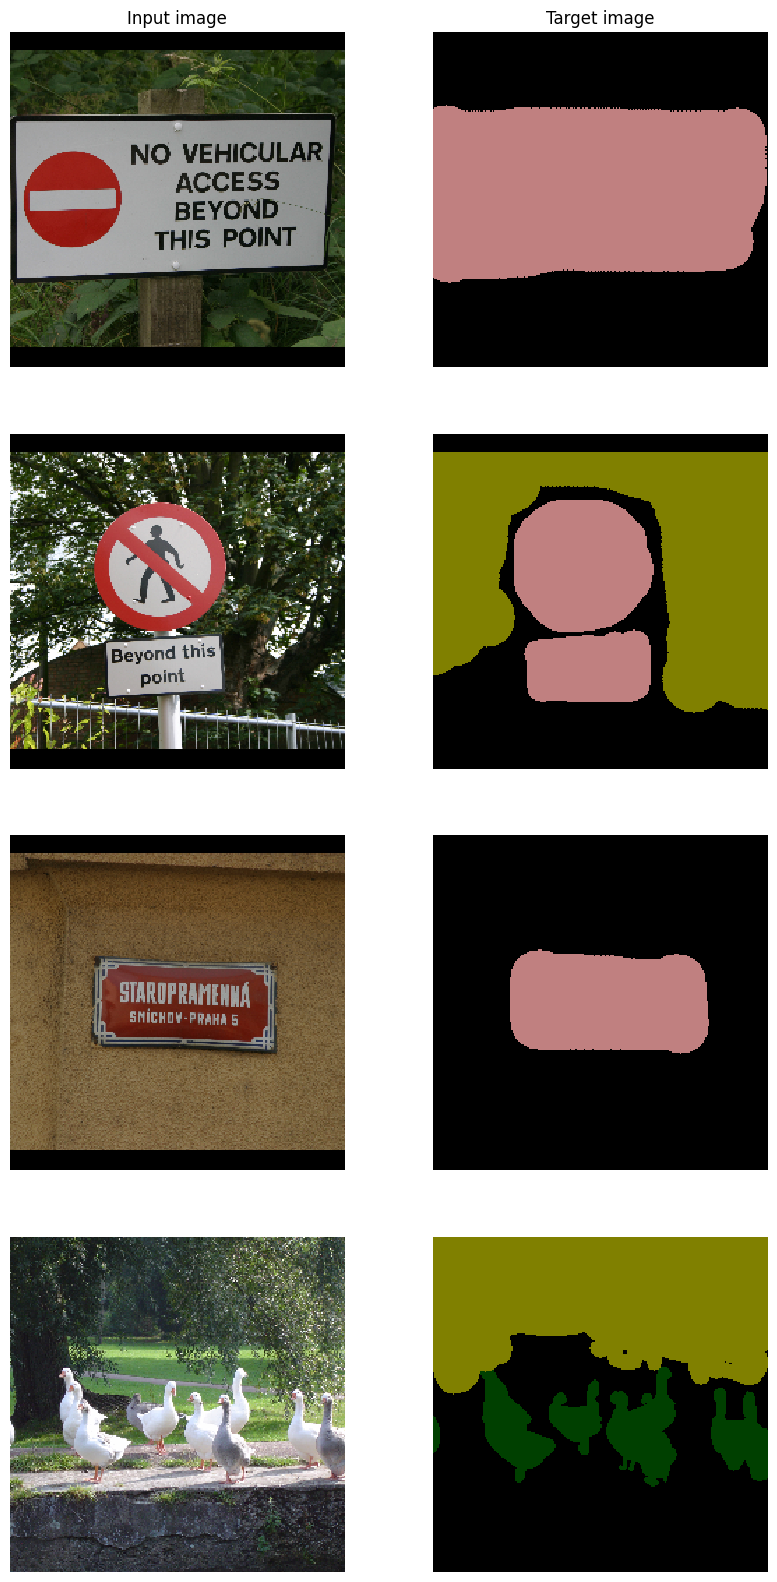

In [22]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 4
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    plt.imshow(label_img_to_rgb(target.numpy()))
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

As you can see, the dataset is considerably smaller when compared to our previous datasets. For instance, CIFAR10 consisted of thousands of images, whereas in this case, we only have 276 training images. Moreover, the task itself is significantly more challenging than a "simple 10 class classification" because we need to assign a label to every individual pixel. What's more, the images are much bigger as we are now considering images of size 240x240 instead of 32x32. 

Given these factors, it's important to set realistic expectations regarding the performance of our networks, so don't be too disappointed.

# 2. Semantic Segmentation 

## Dummy Model

In `exercise_code/networks/segmentation_nn.py` we define a naive `DummySegmentationModel`, which always predicts the scores of segmentation labels of the first image. Let's try it on a few images and visualize the outputs using the `visualizer` we provide. The `visualizer` takes in the model and dataset, and visualizes the first three (Input, Target, Prediction) pairs. 

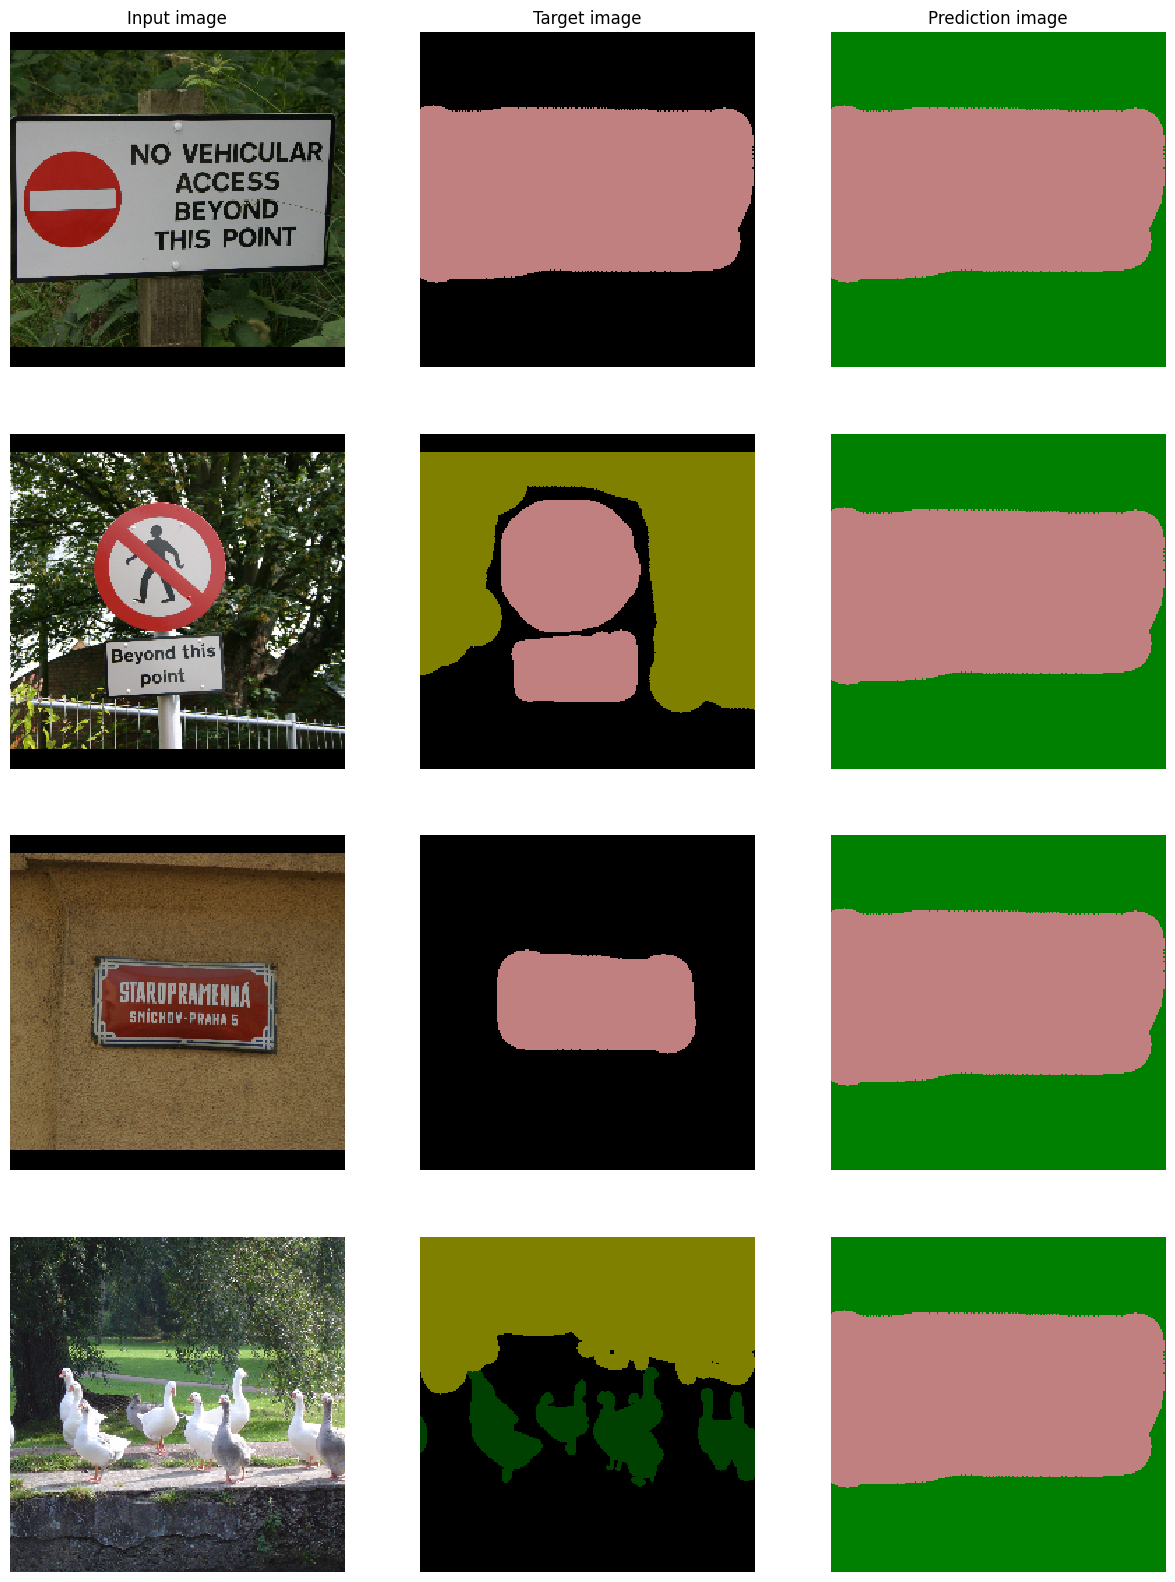

In [23]:
dummy_model = DummySegmentationModel(target_image=train_data[0][1])

# Visualization function
visualizer(dummy_model, train_data)

You can use the visualizer function in your training scenario to print out your model predictions on a regular basis.

## Loss and Metrics
In the context of image segmentation, the loss function employed is pixel-wise cross entropy loss. This particular loss function operates at the pixel level, considering each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector. 
<img src='https://i2dl.vc.in.tum.de/static/images/exercise_10/loss_img.png' width=80% height=80%/>
source: https://www.jeremyjordan.me/semantic-segmentation/

Up until now we only used the default loss function (`nn.CrossEntropyLoss`) in our solvers. However, In order to ignore the `unlabeled` pixels for the computation of our loss, we need to use a customized version of the loss for the initialization of our segmentation solver. The `ignore_index` argument of the loss can be used to filter the `unlabeled` pixels and computes the loss only over remaining pixels.


In [24]:
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

for (inputs, targets) in train_data[0:4]:
    inputs, targets = inputs, targets
    outputs = dummy_model(inputs.unsqueeze(0))
    losses = loss_func(outputs, targets.unsqueeze(0)).item()
    print("Loss:", losses)

Loss: 2.207542657852173
Loss: 2.9404137134552
Loss: 2.207542896270752
Loss: 3.207542896270752


<div class="alert alert-warning">
    <h3>Note: Non-zero loss for the first sample</h3> 
    <p>The output of our dummy model is one-hot-coded tensor. Since there is <b>softmax</b> function in the <b>nn.CrossEntropyLoss</b> function, the loss is:  
    $$loss(x, class) = - \log \left( \frac{\exp(x[class])}{\Sigma_j \exp (x[j])} \right) = −x[class]+\log \left( \Sigma_j \exp(x[j]) \right)$$
     and the loss will not be zero.    </p>
<p>i.e. for $x=[0, 0, 0, 1],class=3$,$\quad$ the loss: 
$loss(x,class) = -1 +\log(\exp(0)+\exp(0)+\exp(0)+\exp(1)) = 0.7437$ </p>
</div>

To obtain an evaluation accuracy, we can simply compute the average per pixel accuracy of our network for a given image. We will use the following function:

In [25]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    model = model.to(device)
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = (targets >= 0).cpu()
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
print(evaluate_model(dummy_model, test_loader))

0.14179702232915609


You will see reasonably high numbers as your accuracy when you do the training later. The reason behind that is the fact that most output pixels are of a single class and the network can just overfit to common classes such as "grass".

## Step 1: Design your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p>Implement your network architecture in <code>exercise_code/networks/segmentation_nn.py</code>. In this task, you will use pytorch to setup your model.
    </p>
</div>

To compensate for the dimension reduction of a typical convolution layer, you should probably include either a single `nn.Upsample` layer, use a combination of upsampling layers as well as convolutions or even transposed convolutions near the end of your network to get back to the target image shape.

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Perform the forward pass in `forward()`. Input dimension is (N, C, H, W) and output dimension is (N, num_classes, H, W)
* Have less than 5 million parameters
* Have a model size of less than 50MB after saving

Furthermore, you need to pass all your hyperparameters to the model in a single dict `hparams`.

<div class="alert alert-warning">
    <h3>Note: Transfer learning</h3>
    <p>In this exercise, we encourage you to do transfer learning as we learned in exercise 8, since this will boost your model performance and save training time. You can import pretrained models from torchvision in your model and use its feature extractor (e.g. <code>alexnet.features</code>) to get the image feature. Feel free to choose more advanced pretrained model like ResNet, MobileNet for your architecture design.</p>       
</div>

See [here](https://pytorch.org/vision/stable/models.html) for more info of the torchvison pretrained models.


In [39]:
# 定义超参数
hparams = {
    'batch_size': 32,
    'epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5
}

In [40]:
model = SegmentationNN(hp = hparams)
test_seg_nn(model)

Your model has 8.972 mio. params but must have less than 5.000 mio. params. Simplify your model before submitting it. You won't need that many params :)
FileSizeTest passed. Your model is 36.1 MB large
Some tests failed for your model. Tests passed: 1/2


## Step 2: Train your own model

<div class="alert alert-info">
    <h3>Task: Implement</h3>
    <p> In addition to the network itself, you will also need to write the code for the model training.
    </p>
</div>

In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from exercise_code.networks.segmentation_nn import SegmentationNN
from tqdm import tqdm

# 确保CUDA设备正确
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Training on GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Training on MPS - CUDA equivalent for Apple Silicon Chips")
    print("Note: MPS is not fully supported by PyTorch yet and might lead to errors.")
    print("If you encounter any issues, please manually switch to CPU.")
    print("In some cases with MPS, it is better to use 0 workers for dataloader.")
else:
    device = torch.device("cpu")
    print("Training on CPU")

########################################################################
# TODO - Train Your Model                                              #
########################################################################


# 定义DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=hparams['batch_size'], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=hparams['batch_size'], shuffle=False, num_workers=0)

# 定义模型、优化器和损失函数
model = SegmentationNN(hp=hparams).to(device)
optimizer = optim.Adam(model.parameters(), lr=hparams['learning_rate'], weight_decay=hparams['weight_decay'])
loss_func = nn.CrossEntropyLoss()

# 创建进度条
def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable), total=len(iterable), ncols=150, desc=desc)

# 训练函数
def train_model(model, train_loader, val_loader, loss_func, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')

        for batch_idx, (inputs, targets) in training_loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # 确保目标张量的值范围在 [0, num_classes-1] 之间
            targets = torch.clamp(targets, 0, model.classifier[-1].out_channels - 1)

            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            training_loop.set_postfix(train_loss="{:.6f}".format(training_loss / (batch_idx + 1)))

        model.eval()
        validation_loss = 0.0
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]')
        with torch.no_grad():
            for batch_idx, (inputs, targets) in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)

                # 确保目标张量的值范围在 [0, num_classes-1] 之间
                targets = torch.clamp(targets, 0, model.classifier[-1].out_channels - 1)

                loss = loss_func(outputs, targets)
                validation_loss += loss.item()
                val_loop.set_postfix(val_loss="{:.6f}".format(validation_loss / (batch_idx + 1)))

        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {training_loss / len(train_loader):.6f}, Validation Loss: {validation_loss / len(val_loader):.6f}")

# 训练模型
train_model(model, train_loader, val_loader, loss_func, optimizer, hparams['epochs'], device)
#######################################################################
#                           END OF YOUR CODE                          #
#######################################################################


Training on GPU


Validation Epoch [1/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.84it/s, val_loss=3.036034]


Epoch 1/50 - Training Loss: 2.970954, Validation Loss: 3.036034


Validation Epoch [2/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=2.455505]


Epoch 2/50 - Training Loss: 2.467804, Validation Loss: 2.455505


Validation Epoch [3/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s, val_loss=1.952427]


Epoch 3/50 - Training Loss: 2.041143, Validation Loss: 1.952427


Validation Epoch [4/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s, val_loss=1.746891]


Epoch 4/50 - Training Loss: 1.697206, Validation Loss: 1.746891


Validation Epoch [5/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.87it/s, val_loss=1.533980]


Epoch 5/50 - Training Loss: 1.443888, Validation Loss: 1.533980


Validation Epoch [6/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s, val_loss=1.363046]


Epoch 6/50 - Training Loss: 1.259127, Validation Loss: 1.363046


Validation Epoch [7/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s, val_loss=1.282343]


Epoch 7/50 - Training Loss: 1.149142, Validation Loss: 1.282343


Validation Epoch [8/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s, val_loss=1.174335]


Epoch 8/50 - Training Loss: 1.005230, Validation Loss: 1.174335


Validation Epoch [9/50]: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.73it/s, val_loss=1.122701]


Epoch 9/50 - Training Loss: 0.891673, Validation Loss: 1.122701


Validation Epoch [10/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s, val_loss=1.017524]


Epoch 10/50 - Training Loss: 0.806819, Validation Loss: 1.017524


Validation Epoch [11/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s, val_loss=0.972596]


Epoch 11/50 - Training Loss: 0.733897, Validation Loss: 0.972596


Validation Epoch [12/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s, val_loss=0.904551]


Epoch 12/50 - Training Loss: 0.677043, Validation Loss: 0.904551


Validation Epoch [13/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s, val_loss=0.868082]


Epoch 13/50 - Training Loss: 0.607555, Validation Loss: 0.868082


Validation Epoch [14/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.825427]


Epoch 14/50 - Training Loss: 0.551193, Validation Loss: 0.825427


Validation Epoch [15/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.789221]


Epoch 15/50 - Training Loss: 0.514890, Validation Loss: 0.789221


Validation Epoch [16/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s, val_loss=0.751394]


Epoch 16/50 - Training Loss: 0.497713, Validation Loss: 0.751394


Validation Epoch [17/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.41it/s, val_loss=0.738382]


Epoch 17/50 - Training Loss: 0.461350, Validation Loss: 0.738382


Validation Epoch [18/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s, val_loss=0.718677]


Epoch 18/50 - Training Loss: 0.424104, Validation Loss: 0.718677


Validation Epoch [19/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.67it/s, val_loss=0.714368]


Epoch 19/50 - Training Loss: 0.397393, Validation Loss: 0.714368


Validation Epoch [20/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s, val_loss=0.712008]


Epoch 20/50 - Training Loss: 0.378433, Validation Loss: 0.712008


Validation Epoch [21/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.63it/s, val_loss=0.706354]


Epoch 21/50 - Training Loss: 0.364091, Validation Loss: 0.706354


Validation Epoch [22/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.688669]


Epoch 22/50 - Training Loss: 0.345582, Validation Loss: 0.688669


Validation Epoch [23/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s, val_loss=0.691364]


Epoch 23/50 - Training Loss: 0.353518, Validation Loss: 0.691364


Validation Epoch [24/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s, val_loss=0.668061]


Epoch 24/50 - Training Loss: 0.329881, Validation Loss: 0.668061


Validation Epoch [25/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.661093]


Epoch 25/50 - Training Loss: 0.311658, Validation Loss: 0.661093


Validation Epoch [26/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.57it/s, val_loss=0.663963]


Epoch 26/50 - Training Loss: 0.301575, Validation Loss: 0.663963


Validation Epoch [27/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s, val_loss=0.674275]


Epoch 27/50 - Training Loss: 0.290066, Validation Loss: 0.674275


Validation Epoch [28/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s, val_loss=0.661909]


Epoch 28/50 - Training Loss: 0.285016, Validation Loss: 0.661909


Validation Epoch [29/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.42it/s, val_loss=0.684466]


Epoch 29/50 - Training Loss: 0.275100, Validation Loss: 0.684466


Validation Epoch [30/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s, val_loss=0.637095]


Epoch 30/50 - Training Loss: 0.276083, Validation Loss: 0.637095


Validation Epoch [31/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.77it/s, val_loss=0.662728]


Epoch 31/50 - Training Loss: 0.272168, Validation Loss: 0.662728


Validation Epoch [32/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, val_loss=0.667345]


Epoch 32/50 - Training Loss: 0.252158, Validation Loss: 0.667345


Validation Epoch [33/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, val_loss=0.684636]


Epoch 33/50 - Training Loss: 0.252679, Validation Loss: 0.684636


Validation Epoch [34/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.664892]


Epoch 34/50 - Training Loss: 0.241271, Validation Loss: 0.664892


Validation Epoch [35/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.661052]


Epoch 35/50 - Training Loss: 0.234736, Validation Loss: 0.661052


Validation Epoch [36/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, val_loss=0.657069]


Epoch 36/50 - Training Loss: 0.232570, Validation Loss: 0.657069


Validation Epoch [37/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.53it/s, val_loss=0.655393]


Epoch 37/50 - Training Loss: 0.229520, Validation Loss: 0.655393


Validation Epoch [38/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.78it/s, val_loss=0.703863]


Epoch 38/50 - Training Loss: 0.223893, Validation Loss: 0.703863


Validation Epoch [39/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s, val_loss=0.706847]


Epoch 39/50 - Training Loss: 0.225820, Validation Loss: 0.706847


Validation Epoch [40/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.49it/s, val_loss=0.702778]


Epoch 40/50 - Training Loss: 0.216992, Validation Loss: 0.702778


Validation Epoch [41/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.705624]


Epoch 41/50 - Training Loss: 0.218595, Validation Loss: 0.705624


Validation Epoch [42/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.71it/s, val_loss=0.697893]


Epoch 42/50 - Training Loss: 0.217324, Validation Loss: 0.697893


Validation Epoch [43/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.70it/s, val_loss=0.712803]


Epoch 43/50 - Training Loss: 0.206979, Validation Loss: 0.712803


Validation Epoch [44/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.79it/s, val_loss=0.699163]


Epoch 44/50 - Training Loss: 0.215035, Validation Loss: 0.699163


Validation Epoch [45/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s, val_loss=0.715131]


Epoch 45/50 - Training Loss: 0.198396, Validation Loss: 0.715131


Validation Epoch [46/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.71it/s, val_loss=0.680433]


Epoch 46/50 - Training Loss: 0.209518, Validation Loss: 0.680433


Validation Epoch [47/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s, val_loss=0.673918]


Epoch 47/50 - Training Loss: 0.199988, Validation Loss: 0.673918


Validation Epoch [48/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.48it/s, val_loss=0.682214]


Epoch 48/50 - Training Loss: 0.195571, Validation Loss: 0.682214


Validation Epoch [49/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.76it/s, val_loss=0.687697]


Epoch 49/50 - Training Loss: 0.190374, Validation Loss: 0.687697


Validation Epoch [50/50]: 100%|██████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.80it/s, val_loss=0.699689]

Epoch 50/50 - Training Loss: 0.190150, Validation Loss: 0.699689


# 3. Test your Model

In [33]:
# model.to(torch.device('cpu'))
# device = torch.device('cpu')
# test(evaluate_model(model, test_loader))
# # why cpu? strange...

# i use gpu so here it is gpu
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)
test(evaluate_model(model, test_loader))

Using device:  cuda:0
Validation-Accuracy: 87.7082997886098%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


# 4. Visualization

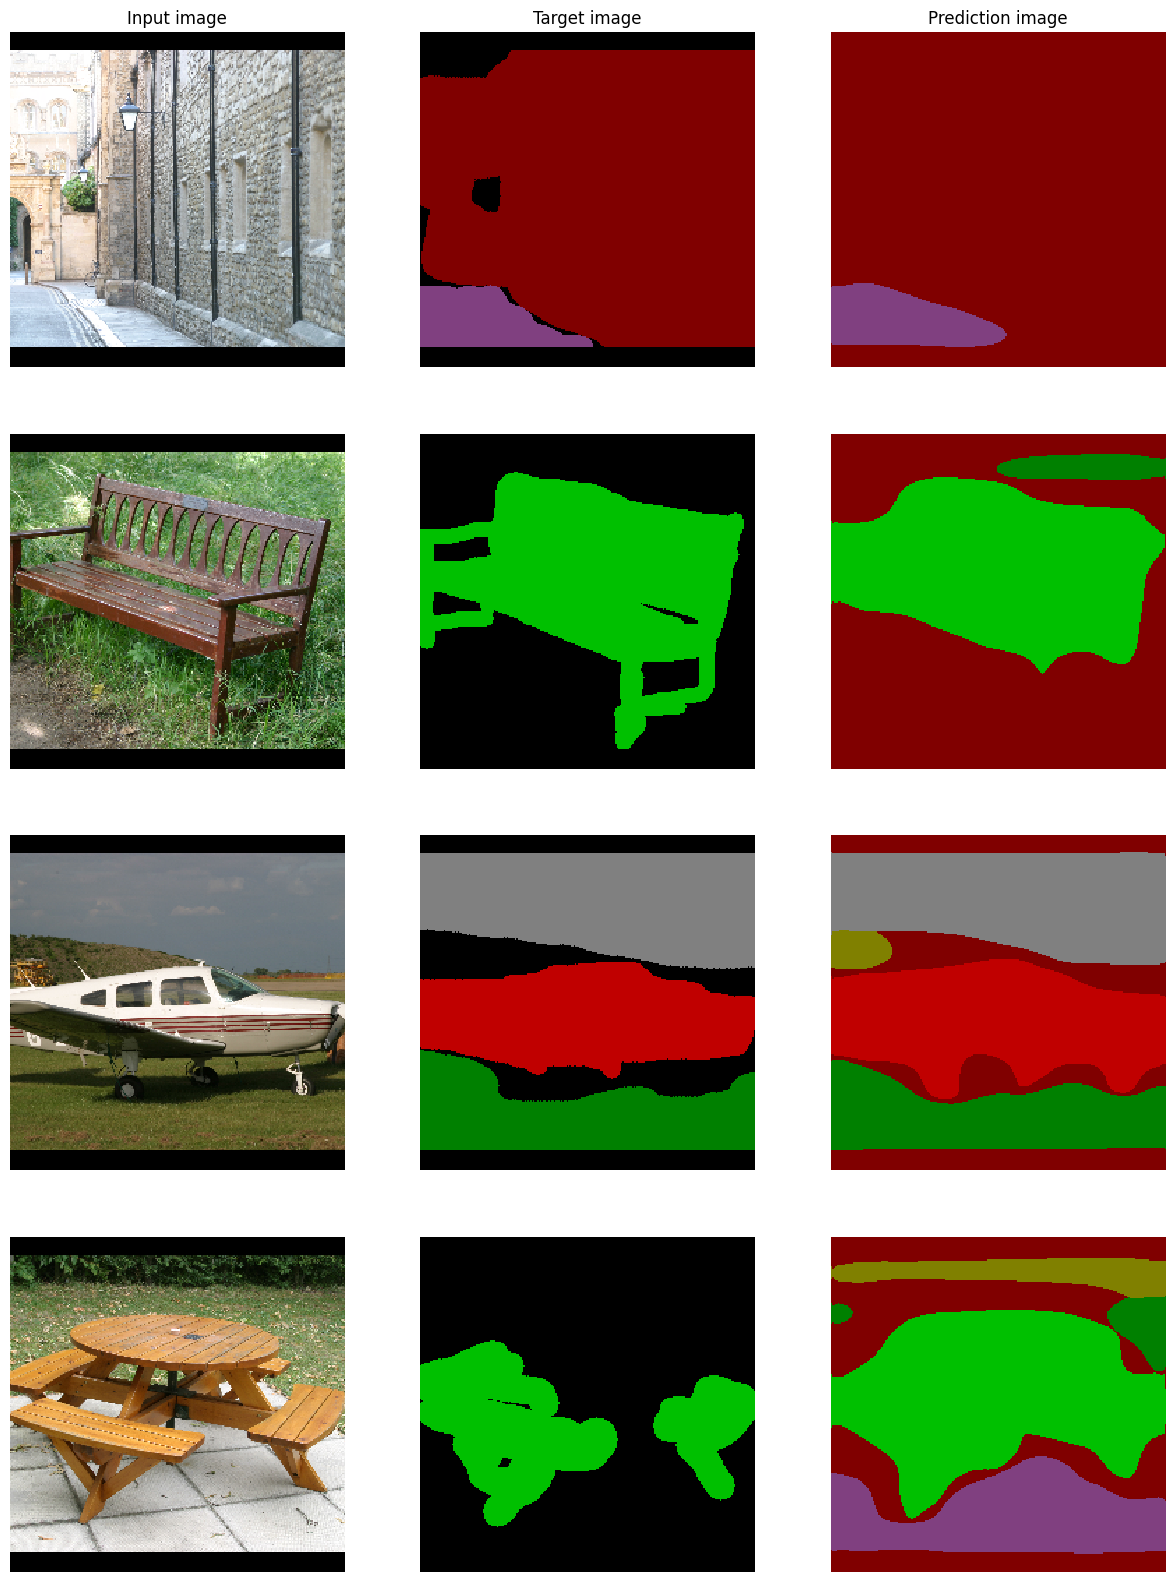

In [34]:
visualizer(model, test_data)

## Save the Model for Submission

 Once you are satisfied with the training of your model, you need to save it for submission. To be eligible for the bonus, you must attain an accuracy exceeding __64%__.

In [35]:
os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")
checkSize(path = "./models/segmentation_nn.model")

Great! Your model size is 36.2 MB, which is less than 50 MB and will be accepted :)


True

In [36]:
from exercise_code.util.submit import submit_exercise

submit_exercise('../output/exercise10')

relevant folders: ['exercise_code', 'models']
notebooks files: ['1_segmentation_nn.ipynb']
Adding folder exercise_code
Adding folder models
Adding notebook 1_segmentation_nn.ipynb
Zipping successful! Zip is stored under: /home/lukas/Desktop/I2DL-homework/output/exercise10.zip


# Submission Instructions

Congratulations! You've just built your first semantic segmentation model with PyTorch! To complete the exercise, submit your final model to [the submission server](https://i2dl.vc.in.tum.de/) - you probably know the procedure by now.


# Submission Goals

- Goal: Implement and train a convolutional neural network for Semantic Segmentation.
- Passing Criteria: Reach **Accuracy >= 64%** on __our__ test dataset. The submission system will show you your score after you submit.
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus